### Revision coverage analysis

This notebook is aimed at calculating the coverage of the genome using short read illumina data mapped with bwa againts primary contigs and primary contigs + haplotigs.

* calculate the coverage in 1000 bp sliding windows (200bp) for p and p+h mapping.
* calculate the coverage when mapping against primary contigs in regions with h overlap and without
* plot those out and see

In [1]:
%matplotlib inline

In [203]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib

In [4]:
#Define some PATH variables
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly'
COV_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/cov_analysis'
OUT_PATH = os.path.join(COV_PATH, 'analysis')
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)

In [20]:
#define some filenames for assembly files
p_fn = os.path.join(BASE_AA_PATH, 'Pst_104E_v13_p_ctg.fa')
ph_fn = os.path.join(BASE_AA_PATH,'combined_assembly', 'Pst_104E_v13_ph_ctg.fa')
p_genome_file_fn = os.path.join(BASE_AA_PATH, 'Pst_104E_v13_p_ctg.genome_file')
ph_genome_file_fn = os.path.join(BASE_AA_PATH,'combined_assembly', \
                                 'Pst_104E_v13_ph_ctg.genome_file')
#and mapping bam files
pbam_fn = os.path.join(COV_PATH, 'Pst_104E_v13_p_ctg.bwamem.Pst79_folder5.sam.sorted.bam')
phbam_fn = os.path.join(COV_PATH, 'Pst_104E_v13_ph_ctg.bwamem.Pst79_folder5.sam.sorted.bam')

In [21]:
#now generate the genmoe files if not present yet
if not os.path.exists(p_genome_file_fn):
    !samtools faidx {p_fn}
    !cat {p_fn}.fai | sort -k1,1n | cut -f 1,2 > {p_genome_file_fn}

if not os.path.exists(ph_genome_file_fn):
    !samtools faidx {ph_fn}
    !cat {ph_fn}.fai | sort -k1,1n | cut -f 1,2 > {ph_genome_file_fn}

In [26]:
#now get in the file name of haplotigs mapping on primary contigs
h_on_p_fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/Pst_104E_v12_p_ctg.p_by_h_cov.gff'

In [46]:
#now make some window files
p_window_1k200_bed = BedTool().window_maker(g=p_genome_file_fn, w=1000, s=200)
ph_window_1k200_bed = BedTool().window_maker(g=ph_genome_file_fn, w=1000, s=200)

In [47]:
#now read in the gff file as bed and get the corresponding window beds
gff3sort_pl = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/get_homologues/gff3sort/gff3sort.pl'
!perl {gff3sort_pl} {h_on_p_fn} > {h_on_p_fn.replace('.gff', '.sorted.gff')}
h_on_p_sorted_fn = h_on_p_fn.replace('.gff', '.sorted.gff')

In [48]:
#now get read in the gff file as bed and get the corresponding window beds. now for real
h_on_p_bed = BedTool(fn=h_on_p_sorted_fn)
h_on_p_bed_pos_1k200_bed = p_window_1k200_bed.intersect(h_on_p_bed)
h_on_p_bed_neg_1k200_bed = p_window_1k200_bed.subtract(h_on_p_bed)

In [49]:
#now read in the bam files as beds
pbam_bed = BedTool(fn=pbam_fn)
phbam_bed = BedTool(fn=phbam_fn)

In [ ]:
#now generate the overlap dataframe
p_window_1k200_cov = p_window_1k200_bed.coverage(pbam_bed)
ph_window_1k200_cov = ph_window_1k200_bed.coverage(phbam_bed)


In [87]:
h_on_p_p_window_1k200_cov = h_on_p_bed_pos_1k200_bed.coverage(phbam_bed)

In [88]:
h_not_on_p_p_window_1k200_cov = h_on_p_bed_neg_1k200_bed.coverage(phbam_bed)

In [51]:
print('hello')

hello


In [68]:
p_window_1k200_cov_df = p_window_1k200_cov.to_dataframe()

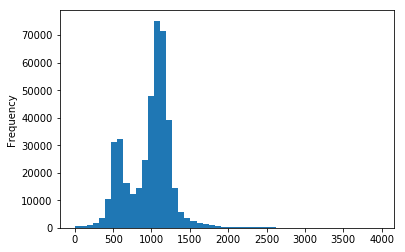

In [69]:
p_window_1k200_cov_df[p_window_1k200_cov_df['name'] < 4000]['name'].plot.hist(bins=50)

In [70]:
ph_window_1k200_cov_df = ph_window_1k200_cov.to_dataframe()

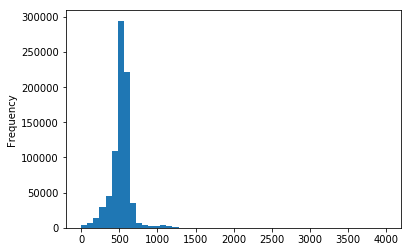

In [71]:
ph_window_1k200_cov_df[ph_window_1k200_cov_df['name'] < 4000]['name'].plot.hist(bins=50)

In [74]:
#define some outfile names
p_window_1k200_fn = os.path.join(OUT_PATH, 'Pst_104E_v13_p_ctg.p_window_1k200.cov')
ph_window_1k200_fn = os.path.join(OUT_PATH, 'Pst_104E_v13_ph_ctg.ph_window_1k200.cov')
p_h_on_p_window_1k200_fn = os.path.join(OUT_PATH, \
                                        'Pst_104E_v13_p_ctg.h_on_p.p_window_1k200.cov')
p_h_not_on_p_window_1k200_fn = os.path.join(OUT_PATH, \
                                        'Pst_104E_v13_p_ctg.h_not_on_p.p_window_1k200.cov')

In [85]:
#save out the bed files for overlaps
p_window_1k200_bed.saveas(p_window_1k200_fn.replace('.cov', '.bed'))
ph_window_1k200_bed.saveas(ph_window_1k200_fn.replace('.cov','.bed'))
h_on_p_bed_pos_1k200_bed.saveas(p_h_on_p_window_1k200_fn.replace('.cov', '.bed'))
h_on_p_bed_neg_1k200_bed.saveas(p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed'))

<BedTool(/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/cov_analysis/analysis/Pst_104E_v13_p_ctg.h_not_on_p.p_window_1k200.bed)>

In [86]:
#save out the overlap files
ph_window_1k200_cov_df.to_csv(ph_window_1k200_fn, sep = '\t', index=None)
p_window_1k200_cov_df.to_csv(p_window_1k200_fn, sep = '\t', index=None)

In [ ]:
#run samtools bedcov command for overlap analysis
!samtools bedcov {p_window_1k200_fn.replace('.cov', '.bed')} {pbam_fn} > {p_window_1k200_fn.replace('.cov', '.samcov')}
!samtools bedcov {ph_window_1k200_fn.replace('.cov', '.bed')} {phbam_fn} > {ph_window_1k200_fn.replace('.cov', '.samcov')}
!samtools bedcov {p_h_on_p_window_1k200_fn.replace('.cov', '.bed')} {phbam_fn} > {p_h_on_p_window_1k200_fn.replace('.cov', '.samcov')}
!samtools bedcov {p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed')} {phbam_fn} > {p_h_not_on_p_window_1k200_fn.replace('.cov', '.samcov')}

[W::hts_idx_load2] The index file is older than the data file: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/cov_analysis/Pst_104E_v13_p_ctg.bwamem.Pst79_folder5.sam.sorted.bam.bai


In [280]:
pbam_fn

'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/cov_analysis/Pst_104E_v13_p_ctg.bwamem.Pst79_folder5.sam.sorted.bam'

In [ ]:
!samtools bedcov {p_h_on_p_window_1k200_fn.replace('.cov', '.bed')} {pbam_fn} > {p_h_on_p_window_1k200_fn.replace('.cov', '.p_mapping.samcov')}
!samtools bedcov {p_h_not_on_p_window_1k200_fn.replace('.cov', '.bed')} {pbam_fn} > {p_h_not_on_p_window_1k200_fn.replace('.cov', '.p_mapping.samcov')}

[W::hts_idx_load2] The index file is older than the data file: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/cov_analysis/Pst_104E_v13_p_ctg.bwamem.Pst79_folder5.sam.sorted.bam.bai


In [182]:
def samcov_slurp(file_name, fil=True):
    samcov_header = ['contig', 'start', 'stop', 'total_cov']
    df = pd.read_csv(file_name, sep='\t', header=None, names=samcov_header)
    df['ave_cov'] = df.total_cov/(df.stop-df.start)
    #rounder = pd.Series([0,0,0,0,2], index = df.columns)
    df.ave_cov = df.ave_cov.round()
    if fil == True:
        low = 0 #these were defined empirical based on the iqr caculations using 0.01 
        high = 400 #and 0.99 as cut off.
        df = df[(df.ave_cov >= low) & (df.ave_cov <= high)]
    return df

In [197]:
#now read in the samtools bedcov files
p_window_1k200_samcov_df = samcov_slurp(p_window_1k200_fn.replace('.cov', '.samcov'))
ph_window_1k200_samcov_df = samcov_slurp(ph_window_1k200_fn.replace('.cov', '.samcov'))
p_h_on_p_window_1k200_samcov_df = samcov_slurp(p_h_on_p_window_1k200_fn.replace('.cov', '.samcov'))
p_h_not_on_p_window_1k200_samcov_df = samcov_slurp(p_h_not_on_p_window_1k200_fn.replace('.cov', '.samcov'))

In [216]:
p_window_1k200_samcov_uf_df = samcov_slurp(p_window_1k200_fn.replace('.cov', '.samcov'),fil=False)
ph_window_1k200_samcov_uf_df = samcov_slurp(ph_window_1k200_fn.replace('.cov', '.samcov'),fil=False)
p_h_on_p_window_1k200_samcov_uf_df = samcov_slurp(p_h_on_p_window_1k200_fn.replace('.cov', '.samcov'),fil=False)
p_h_not_on_p_window_1k200_samcov_uf_df = samcov_slurp(p_h_not_on_p_window_1k200_fn.replace('.cov', '.samcov'),fil=False)

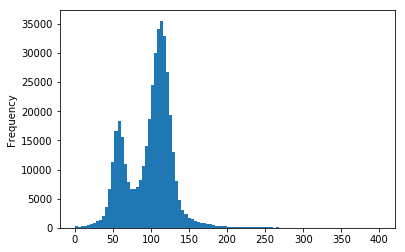

In [189]:
p_window_1k200_samcov_df.ave_cov.plot.hist(bins=100)

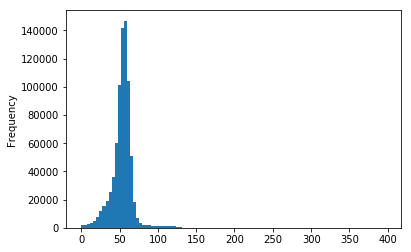

In [190]:
ph_window_1k200_samcov_df.ave_cov.plot.hist(bins=100)

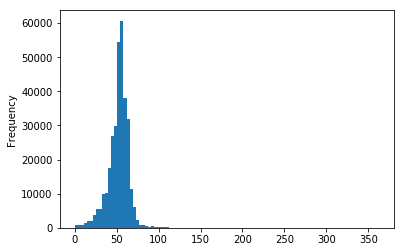

In [191]:
p_h_on_p_window_1k200_samcov_df.ave_cov.plot.hist(bins=100)

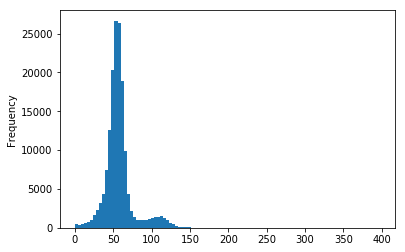

In [192]:
p_h_not_on_p_window_1k200_samcov_df.ave_cov.plot.hist(bins=100)

In [198]:
ph_window_1k200_p_samcov_df = ph_window_1k200_samcov_df[ph_window_1k200_samcov_df.contig.str.startswith('p')] 

In [199]:
ph_window_1k200_h_samcov_df = ph_window_1k200_samcov_df[ph_window_1k200_samcov_df.contig.str.startswith('h')] 

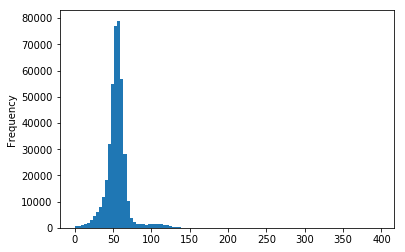

In [200]:
ph_window_1k200_p_samcov_df.ave_cov.plot.hist(bins=100)

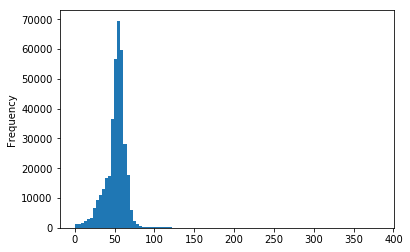

In [201]:
ph_window_1k200_h_samcov_df.ave_cov.plot.hist(bins=100)

In [204]:
#histogram of 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

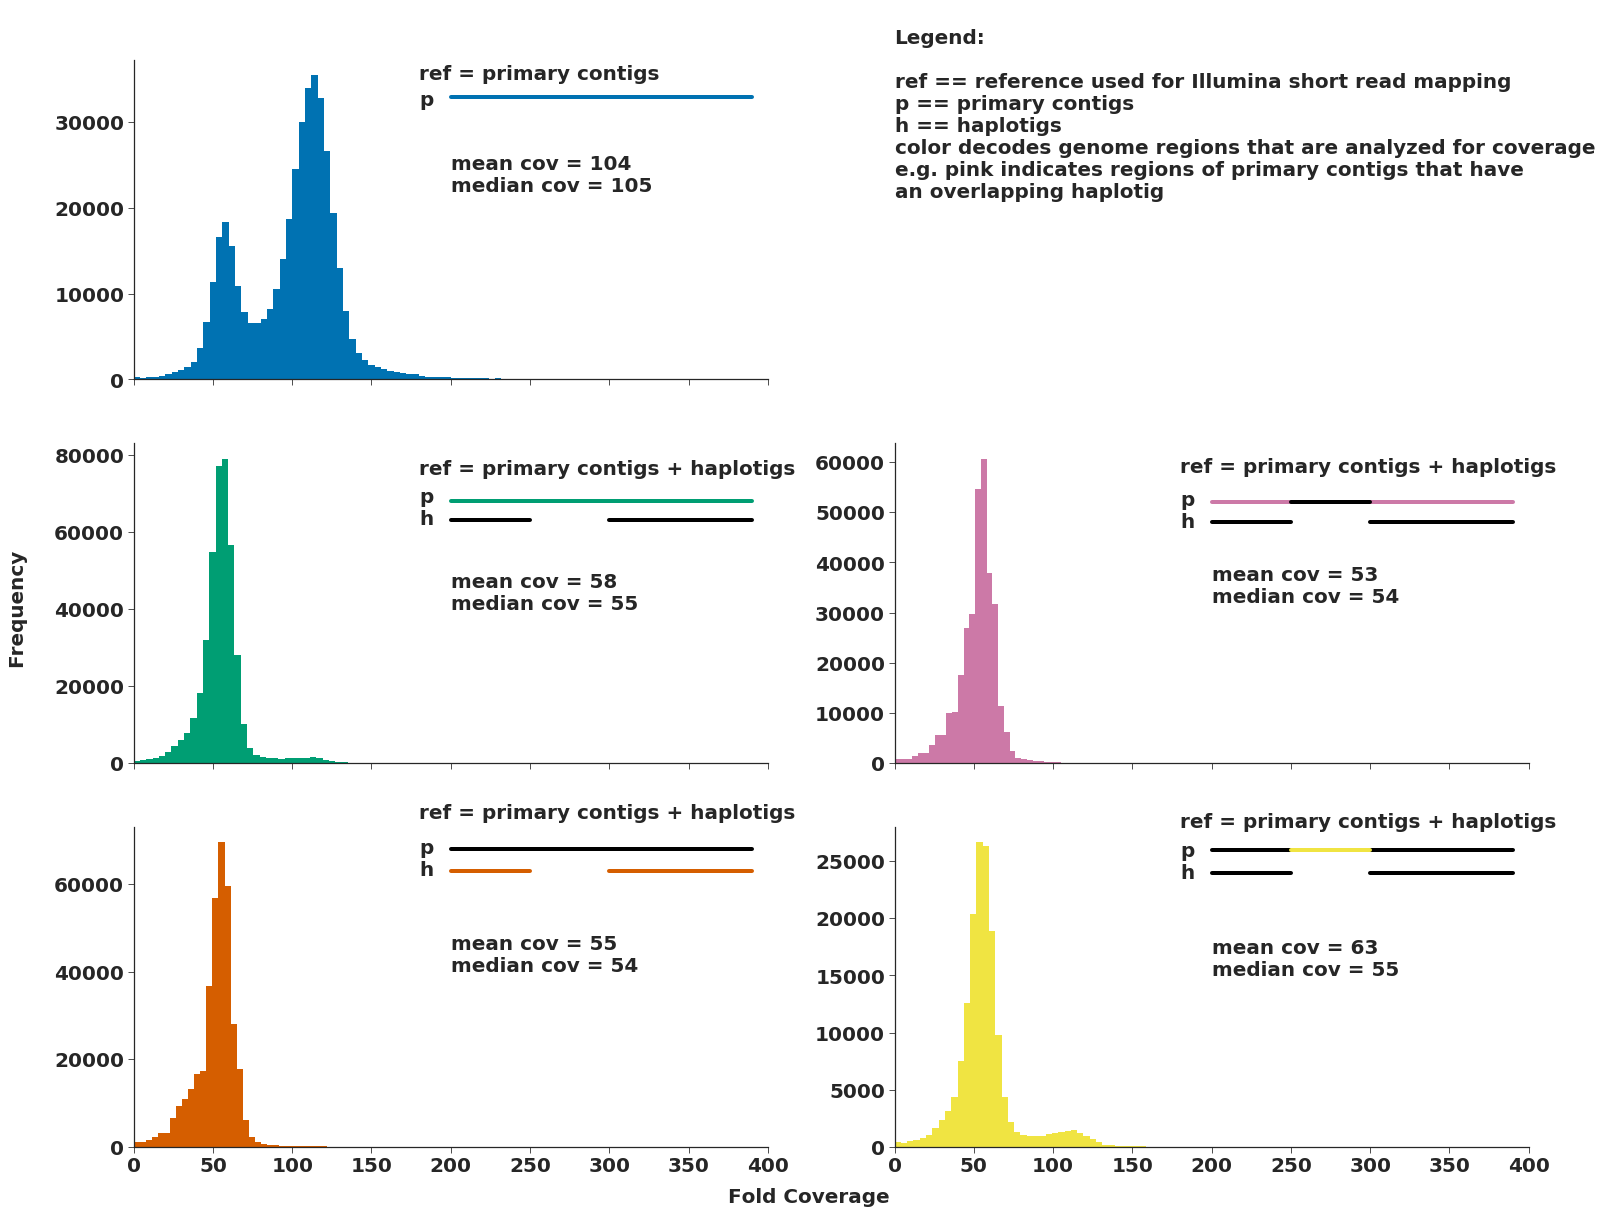

In [278]:
#now do the figure
fig, ax1 = plt.subplots(3, 2, figsize=(25,20), sharex='all')
#set style
sns.set_style("ticks")
sns.despine()
pallete = sns.color_palette('colorblind')


ax1[0,0].hist(p_window_1k200_samcov_df.ave_cov, bins=100, color=pallete[0])
ax1[0,0].text(200, 22000, 'mean cov = %i\nmedian cov = %i' % \
             (p_window_1k200_samcov_uf_df.ave_cov.mean(),\
              p_window_1k200_samcov_uf_df.ave_cov.median() ))
ax1[0,0].text(180, 35000, 'ref = primary contigs')
ax1[0,0].plot([200, 390], [33000, 33000], lw =4, color = pallete[0])
ax1[0,0].text(180, 32000, 'p')
ax1[0,0].set_xlim([0,400])

#now plot the ph mapping with primeray mapping only
ph_p_samcov_df = \
ph_window_1k200_samcov_df[ph_window_1k200_samcov_df.contig.str.startswith('p')] 
ph_p_samcov_un_df = \
ph_window_1k200_samcov_uf_df[ph_window_1k200_samcov_uf_df.contig.str.startswith('p')]

ax1[1,0].hist(ph_p_samcov_df.ave_cov, bins=100, color=pallete[1])
ax1[1,0].text(200, 40000, 'mean cov = %i\nmedian cov = %i' % \
             (ph_p_samcov_un_df.ave_cov.mean(),\
              ph_p_samcov_un_df.ave_cov.median() ))
ax1[1,0].text(180, 75000, 'ref = primary contigs + haplotigs')
ax1[1,0].plot([200, 390], [68000, 68000], lw =4, color = pallete[1])
ax1[1,0].plot([200, 250], [63000, 63000], lw =4, color = 'k')
ax1[1,0].plot([300, 390], [63000, 63000], lw =4, color = 'k')
ax1[1,0].text(180, 62000, 'p\nh')
ax1[1,0].set_xlim([0,400])


#now plot the ph mapping with haplotig mapping only
ph_h_samcov_df = \
ph_window_1k200_samcov_df[ph_window_1k200_samcov_df.contig.str.startswith('h')] 
ph_h_samcov_un_df = \
ph_window_1k200_samcov_uf_df[ph_window_1k200_samcov_uf_df.contig.str.startswith('h')]

ax1[2,0].hist(ph_h_samcov_df.ave_cov, bins=100, color=pallete[2])
ax1[2,0].text(200, 40000, 'mean cov = %i\nmedian cov = %i' % \
             (ph_h_samcov_un_df.ave_cov.mean(),\
              ph_h_samcov_un_df.ave_cov.median() ))
ax1[2,0].text(180, 75000, 'ref = primary contigs + haplotigs')
ax1[2,0].plot([200, 390], [68000, 68000], lw =4, color = 'k')
ax1[2,0].plot([200, 250], [63000, 63000], lw =4, color = pallete[2])
ax1[2,0].plot([300, 390], [63000, 63000], lw =4, color = pallete[2])
ax1[2,0].text(180, 62000, 'p\nh')
ax1[2,0].set_xlim([0,400])


#now plot the ph mapping with primaries with overlaps
ax1[1,1].hist(p_h_on_p_window_1k200_samcov_df.ave_cov, bins=100, color=pallete[3])
ax1[1,1].text(200, 32000, 'mean cov = %i\nmedian cov = %i' % \
             (p_h_on_p_window_1k200_samcov_uf_df.ave_cov.mean(),\
              p_h_on_p_window_1k200_samcov_uf_df.ave_cov.median() ))
ax1[1,1].text(180, 58000, 'ref = primary contigs + haplotigs')
ax1[1,1].plot([200, 250], [52000, 52000], lw =4, color = pallete[3])
ax1[1,1].plot([300, 390], [52000, 52000], lw =4, color = pallete[3])
ax1[1,1].plot([250, 300], [52000, 52000], lw =4, color = 'k')
ax1[1,1].plot([200, 250], [48000, 48000], lw =4, color = 'k')
ax1[1,1].plot([300, 390], [48000, 48000], lw =4, color = 'k')
ax1[1,1].text(180, 47000, 'p\nh')
ax1[1,1].set_xlim([0,400])

#now plot the ph mapping with primaries with overlaps
ax1[2,1].hist(p_h_not_on_p_window_1k200_samcov_df.ave_cov, bins=100, color=pallete[4])
ax1[2,1].text(200, 15000, 'mean cov = %i\nmedian cov = %i' % \
             (p_h_not_on_p_window_1k200_samcov_uf_df.ave_cov.mean(),\
              p_h_not_on_p_window_1k200_samcov_uf_df.ave_cov.median() ))
ax1[2,1].text(180, 28000, 'ref = primary contigs + haplotigs')
ax1[2,1].plot([200, 250], [26000, 26000], lw =4, color = 'k')
ax1[2,1].plot([300, 390], [26000, 26000], lw =4, color = 'k')
ax1[2,1].plot([250, 300], [26000, 26000], lw =4, color = pallete[4])
ax1[2,1].plot([200, 250], [24000, 24000], lw =4, color = 'k')
ax1[2,1].plot([300, 390], [24000, 24000], lw =4, color = 'k')
ax1[2,1].text(180, 23500, 'p\nh')

ax1[2,1].set_xlim([0,400])

#add the labels
fig.text(0.06, 0.5, 'Frequency', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.09, 'Fold Coverage',ha='center', va='center')

#make plot [0,1] disappear
ax1[0,1].axis('off')
text = '''
Legend:\n
ref == reference used for Illumina short read mapping
p == primary contigs
h == haplotigs
color decodes genome regions that are analyzed for coverage
e.g. pink indicates regions of primary contigs that have
an overlapping haplotig
'''
ax1[0,1].text(0, 0.5, text)
out_fn = os.path.join(OUT_PATH, 'SRM_coverage.png')
fig.savefig(out_fn, dpi=600)

In [224]:
print(ax1[1,1])

Axes(0.547727,0.391471;0.352273x0.222059)


In [ ]:
#add single label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Fold coverage", {
      'fontsize'            : 20,
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center',
        'weight' : 'bold'
      })
plt.ylabel("Frequency")